# Imported Libraries and CSV's

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import log_loss

df = pd.read_csv('blood_donation_train.csv', index_col=0)
df2 = pd.read_csv('blood_donation_test.csv', index_col=0)

# Exploratory Analysis

In [3]:
df.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [99]:
df.describe()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


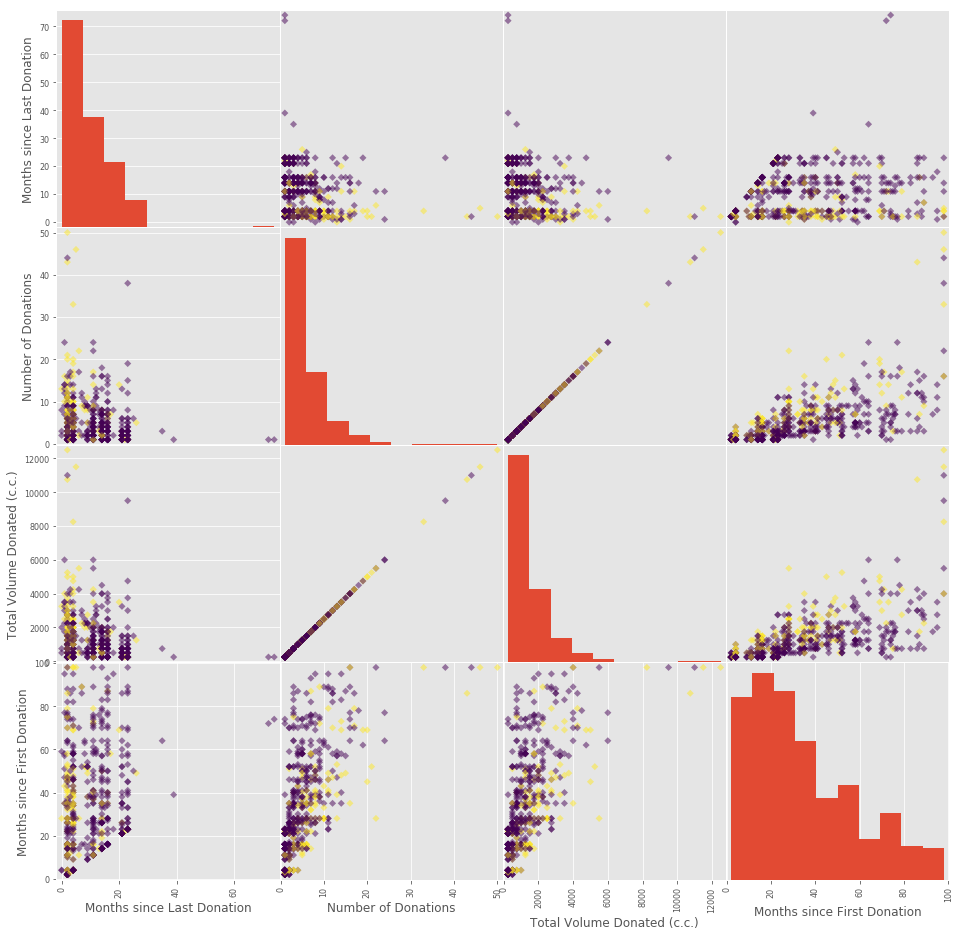

In [3]:
X1 = df.iloc[:,:4]
y1 = df.iloc[:, -1]

plt.style.use('ggplot')
_ = pd.plotting.scatter_matrix(X1, figsize=(16,16), c=y1, marker='D', s=25)

# Preprocessing

In [21]:
X = df.iloc[:,:4]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42, stratify=y)

#Rescaled Data for algorithms that use distance measures like knn
min_max = MinMaxScaler(feature_range=(0, 1))
X_train_mm = min_max.fit_transform(X_train)
X_test_mm = min_max.fit_transform(X_test)

#Rescaled data for models that have attributes with a Gaussian distribution like logistic regression and linear regression
X_train_scaled = StandardScaler().fit(X_train)
rescaledX_train = X_train_scaled.transform(X_train)
X_test_scaled = StandardScaler().fit(X_test)
rescaledX_test = X_train_scaled.transform(X_test)

#Rescaled data for sparse datasets(lots of zeroes). good for neural networks and knn
norm = Normalizer().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)


# Model - KNeighborsClassifier

In [201]:
model = KNeighborsClassifier(n_neighbors=25) 
model.fit(X_train_norm, y_train)
y_pred = model.predict_proba(X_test_norm)[:,1]
score = model.score(X_test_mm, y_test)

param_grid = {'n_neighbors': np.arange(1, 40)}

# Model - LogisticRegression

In [22]:
model = LogisticRegression(C=0.005689866029018299, penalty = 'l1')
model.fit(X_train, y_train)
y_pred = model.predict_proba(rescaledX_test)[:, 1]
score = model.score(X_test, y_test)
param_grid = {'C': np.logspace(-5, 5, 1000), 'penalty': ['l1', 'l2']}

#C=0.005689866029018299, penalty= 'l1'

# Model - DecisionTreeClassifier

In [101]:
model = DecisionTreeClassifier(
                                 criterion='gini'
                               , max_depth=3
                               , max_features=4
                               , min_samples_leaf=3
                               , random_state=0
                              )
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
score = model.score(X_test, y_test)

param_grid = {"max_depth": [3, None],
              "max_features": randint(1, 5),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

#criterion='gini', max_depth=1, max_features=1, min_samples_leaf=1

# Model - SVM

In [205]:
model = SVC(C=1, gamma=0.26232378821631236, probability=True)
model.fit(rescaledX_train, y_train)
y_pred = model.predict_proba(rescaledX_test)[:, 1]

param_grid ={'C':np.arange(1,11),
             'gamma':np.logspace(-5, 4, 500)}

# Hypertuning Parameters

In [194]:
def tuning(m):
    if m=='knn':
        model_cv = GridSearchCV(model, param_grid, cv=5)
        model_cv.fit(X_train_mm, y_train)
    elif m=='logreg':
        model_cv = GridSearchCV(model, param_grid, cv=5)
        model_cv.fit(rescaledX_train, y_train) 
    elif m=='tree': 
        model_cv = RandomizedSearchCV(model, param_grid, cv=5)
        model_cv.fit(X_train, y_train)
    elif m=='svm':
        model_cv = GridSearchCV(model, param_grid, cv=3)
        model_cv.fit(rescaledX_train, y_train)
        
    else:
        return print('ERROR: There was a problem with the parameter input')
    print("Tuned Logistic Regression Parameters: {}".format(model_cv.best_params_)) 
    print("Best score is {}".format(model_cv.best_score_))

tuning(m='svm')

Tuned Logistic Regression Parameters: {'C': 1, 'gamma': 0.26232378821631236}
Best score is 0.7890818858560794


# Model Performance Calculator

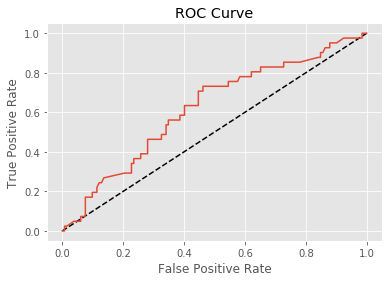

Log Loss = 0.6846714537918378


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Log Loss = {}'.format(log_loss(y_true=y_test ,y_pred=y_pred)))
#print('Accuracy = {}'.format(accuracy_score(y_pred, y_test )))
#print(classification_report(y_test, y_pred))

# Best Scores
# 1. SVM                    - Log Loss = 0.5100998805191709
# 1. Logistic Regression    - Log Loss = 0.5077940775739512 - Actual Score = ?
# 2. ElasticNet             - Log Loss = 0.6870809908884508 - not submitted
# 2. DecisionTreeClassifier - Log Loss = 0.5238225835629183 - not submitted
# 3. KNeighborsClassifier   - Log Loss = 0.5320921921998861 - Actual Score = 0.4986

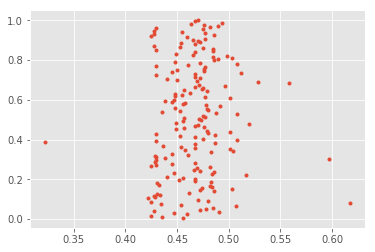

In [11]:
X_graph =  model.predict_proba(rescaledX_test)[:, 1]
y_graph = np.arange(1, len(rescaledX_test)+1)/len(rescaledX_test)

plt.plot(X_graph, y_graph, marker='.', linestyle='none')
plt.show()

In [208]:
#Rescaled Data for algorithms that use distance measures like knn
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_data = min_max.fit_transform(df2)


#Rescaled data for models that have attributes with a Gaussian distribution like logistic regression and linear regression
scaler1 = StandardScaler().fit(df2)
rescaled_data1 = scaler1.transform(df2)

#Rescaled data for sparse datasets(lots of zeroes). good for neural networks and knn
scaler2 = Normalizer().fit(df2)
rescaled_data2 = norm.transform(df2)



answer = model.predict_proba(rescaled_data1)[:,1]
#df2['Made Donation in March 2007'] = answer
prediction_df = pd.DataFrame(columns=['Made Donation in March 2007'], data=answer, index=df2.index )

prediction_df.to_csv('prediction.csv')
